In [3]:
suppressMessages(library('dplyr'))
suppressMessages(library('quantmod'))
suppressMessages(library('repr'))
suppressMessages(library('xlsx'))
suppressMessages(library('derivmkts'))
suppressMessages(library('ggplot2'))
suppressMessages(library('moments'))
suppressMessages(library('bizdays'))
suppressMessages(library('lubridate'))
# This changes the size of plots
options(repr.plot.width = 5.5, repr.plot.height =4)

In [4]:
TSLA_OPTIONS = xlsx::read.xlsx('Data/TSLA_OPTIONS.xlsx', sheetName = "Sheet1")

TSLA_STOCK = xlsx::read.xlsx('Data/TSLA_STOCK.xlsx', sheetName = "Sheet1")


n_row = dim(TSLA_STOCK)[1]
print(paste(c("Total Number of Rows = ", n_row), collapse = ''))

n_col = dim(TSLA_STOCK)[2]
print(paste(c("Total Number of Columns = ", n_col), collapse = ''))

[1] "Total Number of Rows = 717"
[1] "Total Number of Columns = 7"


In [5]:
# convert date to "Date" variable
TSLA_STOCK$Date = as.Date(TSLA_STOCK$Date, format="%Y-%m-%d")

# Sort the column by time
TSLA_STOCK = TSLA_STOCK[rev(order(TSLA_STOCK$Date)),]
str(TSLA_STOCK)

'data.frame':	717 obs. of  7 variables:
 $ Date         : Date, format: "2021-11-03" "2021-11-02" ...
 $ TSLA.Open    : num  1177 1159 1145 1082 1068 ...
 $ TSLA.High    : num  1215 1209 1210 1115 1081 ...
 $ TSLA.Low     : num  1153 1146 1119 1073 1054 ...
 $ TSLA.Close   : num  1214 1172 1209 1114 1077 ...
 $ TSLA.Volume  : num  34628519 42737800 56048700 29918400 27213200 ...
 $ TSLA.Adjusted: num  1214 1172 1209 1114 1077 ...


In [6]:
head(TSLA_STOCK)

,Date,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,TSLA.Volume,TSLA.Adjusted
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
717,2021-11-03,1177.33,1215.39,1152.68,1213.86,34628519,1213.86
716,2021-11-02,1159.36,1208.59,1146.00,1172.00,42737800,1172.00
715,2021-11-01,1145.00,1209.75,1118.66,1208.59,56048700,1208.59
714,2021-10-29,1081.86,1115.21,1073.21,1114.00,29918400,1114.00
713,2021-10-28,1068.31,1081.00,1054.20,1077.04,27213200,1077.04
712,2021-10-27,1039.66,1070.88,1030.78,1037.86,38526500,1037.86


In [7]:
cal <-  create.calendar(name="mycal", weekdays=c("saturday", "sunday"))
start_date = min(TSLA_STOCK$Date); start_date
end_date = max(TSLA_STOCK$Date); end_date
x = as.numeric(bizdays::bizdays(start_date, end_date, cal = cal))

#print(paste(c("Total Number of Trading Days .. ", x), collapse = ''))

[1] "2019-01-02"

[1] "2021-11-03"

In [8]:
colnames(TSLA_STOCK)

[1] "Date"          "TSLA.Open"     "TSLA.High"     "TSLA.Low"     
[5] "TSLA.Close"    "TSLA.Volume"   "TSLA.Adjusted"

### Generate a vector of log returns 

$$\text{Log Returns} = \log\Big(\frac{R_{i}}{R_{i-1}}\Big)$$

In [9]:
log_returns = NULL

In [10]:
for(i in 1:n_row){

    log_returns[i] = log(TSLA_STOCK$TSLA.Close[i] / TSLA_STOCK$TSLA.Open[i])

}

print(log_returns[1:5])
TSLA_STOCK$log_returns = log_returns
head(TSLA_STOCK)

[1] 0.030556227 0.010843575 0.054049726 0.029275373 0.008138558


,Date,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,TSLA.Volume,TSLA.Adjusted,log_returns
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
717,2021-11-03,1177.33,1215.39,1152.68,1213.86,34628519,1213.86,0.030556227
716,2021-11-02,1159.36,1208.59,1146.00,1172.00,42737800,1172.00,0.010843575
715,2021-11-01,1145.00,1209.75,1118.66,1208.59,56048700,1208.59,0.054049726
714,2021-10-29,1081.86,1115.21,1073.21,1114.00,29918400,1114.00,0.029275373
713,2021-10-28,1068.31,1081.00,1054.20,1077.04,27213200,1077.04,0.008138558
712,2021-10-27,1039.66,1070.88,1030.78,1037.86,38526500,1037.86,-0.001732883


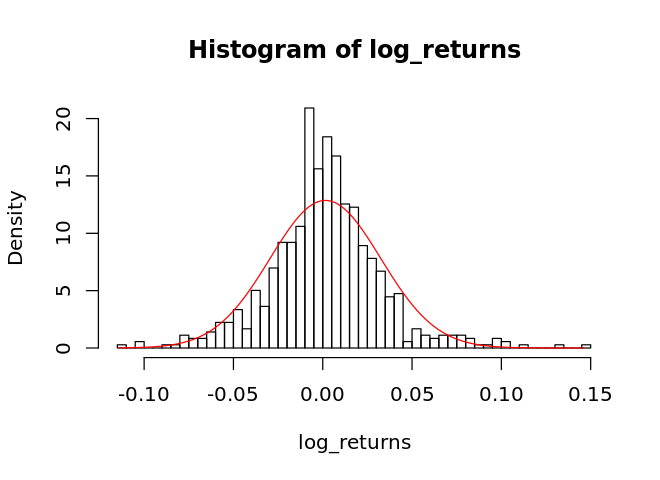

In [11]:
hist(log_returns, breaks = 75, probability = TRUE)

x = seq(min(log_returns),max(log_returns),.001)

y = dnorm(x,mean = mean(log_returns),sd= sd(log_returns))

points(x,y,type = 'l',col='red')


In [12]:
moments::skewness(log_returns) # slightly positive skew..

[1] 0.2844248

In [13]:
shapiro.test(log_returns)


	Shapiro-Wilk normality test

data:  log_returns
W = 0.96894, p-value = 3.355e-11


### Shapiro-Wilk Test

[Penn State - Test for Normality](https://online.stat.psu.edu/stat462/node/147/)


$$H_{0} = \text{The errors follow a normal distribution}$$

$$H_{a} = \text{ The errors do not follow a normal distribution. } $$

- When p-value < Alpha (.05) then we reject the null and accept the alternative. 

- Here p = . 000000000000000022

- Since p < .05, we acccpt the alternative. 

> *The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed.*

### What is the ideal Volatility ? 

In [14]:
X = NULL
Y = NULL
Z = NULL
min_value = 5
count = 0
for(i in min_value:400){
    count = count + 1
    X[count] = i

    Y[count] = (sd(TSLA_STOCK$log_returns[1:i]) * sqrt(252)) *  100
    
    # Standard error... 
    Z[count] = (sd(TSLA_STOCK$log_returns[1:i]) / sqrt(i)) * 100
}

df = data.frame(X, Y, Z)
colnames(df) = c("Number of Trading Days", "Annual Volatility",  "Standard Error")
head(df)

,Number of Trading Days,Annual Volatility,Standard Error
,<int>,<dbl>,<dbl>
1,5,29.32902,0.8262514
2,6,32.01030,0.8232161
3,7,33.70132,0.8024124
4,8,44.86206,0.9991574
5,9,42.25378,0.8872460
6,10,41.01451,0.8170286


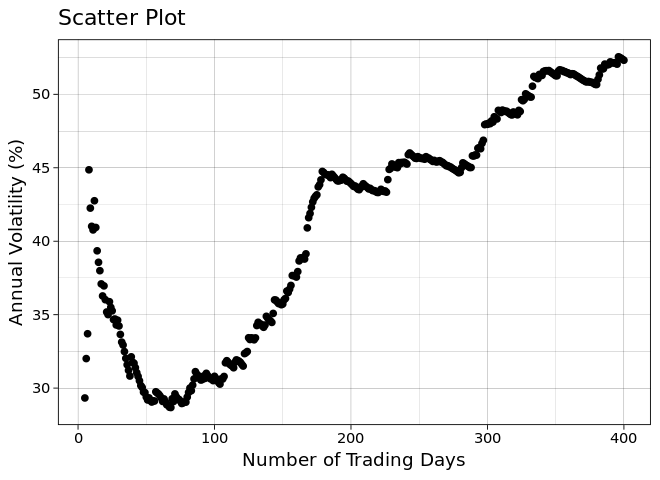

In [84]:
plot_1 <- ggplot(df) +
  geom_point(aes(x = X, y = Y))+
  labs(
    title = "Scatter Plot",
    y = "Annual Volatility (%)",
    x = "Number of Trading Days")

plot_1 + theme_linedraw()  # This is the "theme" for ggplot2